# ttH experiment: inference results

## Setup

In [1]:
import sys
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import torch
from torch.utils.data import TensorDataset
import logging

sys.path.append("../../")

%matplotlib inline

logging.basicConfig(
    format="%(asctime)-5.5s %(name)-30.30s %(levelname)-7.7s %(message)s",
    datefmt="%H:%M",
    level=logging.DEBUG,
)
logger = logging.getLogger(__name__)
# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "manifold_flow" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)


## Load results

In [2]:
algo_filenames = ["flow", "pie", "mf", "gamf",]
algo_labels = ["Flow", "PIE", "Manifold flow", "GAMF"]


In [3]:
result_dir = "../data/results"

model_posterior_samples = []
for algo_filename in algo_filenames:
    try:
        model_posterior_samples.append(np.load(
            "{}/{}_20_tth_true_posterior_samples.npy".format(
                result_dir, algo_filename
            )
        ))
    except FileNotFoundError as e:
        print(e)
        model_posterior_samples.append(np.nan*np.ones((1000,3)))
    
model_posterior_samples = np.asarray(model_posterior_samples)


[Errno 2] No such file or directory: '../data/results/pie_20_tth_true_posterior_samples.npy'
[Errno 2] No such file or directory: '../data/results/mf_20_tth_true_posterior_samples.npy'
[Errno 2] No such file or directory: '../data/results/gamf_20_tth_true_posterior_samples.npy'


## Plot results

In [4]:
model_posterior_samples[0]

array([[ 0.28573649, -0.7036198 ,  0.45852928],
       [ 0.21642009, -0.83413594, -0.01385828],
       [ 0.21642009, -0.83413594, -0.01385828],
       ...,
       [-0.14831174,  0.22855296,  0.08715883],
       [-0.36228207, -0.15982661, -0.24067184],
       [-0.41932777,  0.1655321 , -0.12879679]])

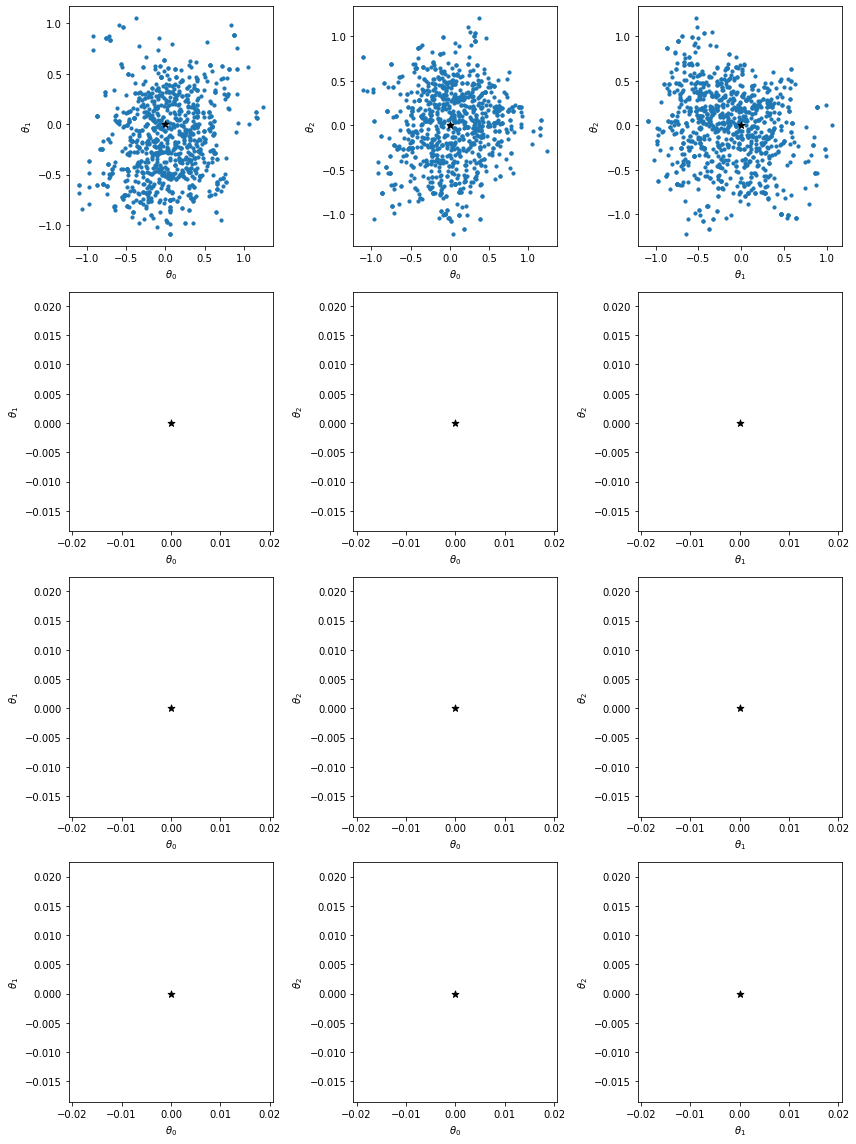

In [5]:
ncols = 3
nrows = len(algo_filenames)

fig = plt.figure(figsize=(ncols*4, nrows*4))

for algo, label in enumerate(algo_labels):
    for i, (ix, iy) in enumerate([(0,1), (0,2), (1,2)]):
        ax = plt.subplot(nrows, ncols, algo*3 + i + 1)
        plt.scatter(model_posterior_samples[algo,:,ix], model_posterior_samples[algo,:,iy], s=10., c="C0")
        plt.scatter([0.], [0.], s=50, marker="*", c="black")

        plt.xlabel(r"$\theta_{}$".format(ix))
        plt.ylabel(r"$\theta_{}$".format(iy))
        #plt.xlim(-1.2,1.2)
        #plt.ylim(-1.2,1.2)
    
plt.tight_layout()
plt.savefig("../figures/posterior_samples_tth.pdf")
